In [1]:
%cd /content/drive/MyDrive/Vis

/content/drive/MyDrive/Vis


In [2]:
!pip install contractions

In [3]:
import numpy as np
import pandas as pd

In [4]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"

df = pd.read_csv('training.1600000.processed.noemoticon.csv',
                 encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

In [5]:
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.tokenize.api import TokenizerI
from nltk.stem import StemmerI, WordNetLemmatizer

import re
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sns
from wordcloud import WordCloud

# sklearn imports
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, RocCurveDisplay, precision_score, recall_score

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [6]:
df = df[['target', 'text']]
df['target'] = df['target'].replace(4, 1)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [7]:
NON_ALNUM_RE = re.compile(r'[^a-zA-Z0-9]')
USER_RE = re.compile('@[^\s]+')
HTTP_URL_RE = re.compile("((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)")
SPACES_RE = re.compile('[\s]+')

# Setup tokenizer and lemmatizer
wn_lemmatizer = WordNetLemmatizer()
tw_tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True)

In [8]:
import contractions
from typing import List
from nltk.corpus import stopwords

In [9]:
def make_ngrams(words: List[str], n: int = 1, log_time: dict = None, log_name: str = None) -> List[str]:
    if n == 1 or not words or n > len(words):
        return words
    # Otherwise we process n-gram windows and proceed
    n_grams = []
    for i in range(len(words) - n + 1):
        n_grams.append('_'.join(words[i:i+n]))
    return n_grams

def stem_and_tokenize(origin_text: str,
                      lemmatizer: WordNetLemmatizer,
                      tokenizer: TokenizerI,
                      n_grams: int = 1,
                      log_time=None) -> List[str]:
    text = origin_text.lower()
    # Replace the URLs and usernames
    text = HTTP_URL_RE.sub(' url', text)
    text = USER_RE.sub('', text)
    # Expand contractions before additional processing
    text = contractions.fix(text)
    # Replace non alpha numeric characters with empty string
    text = NON_ALNUM_RE.sub(' ', text)
    text = SPACES_RE.sub(' ', text)
    # Tokenize the processed text and make n-grams
    tokens = tokenizer.tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return make_ngrams(tokens, n_grams, log_time=log_time)

def make_tokens(row_data: str, n_grams: int = 1) -> List[str]:
  return stem_and_tokenize(row_data, wn_lemmatizer, tw_tokenizer, n_grams=n_grams)

In [10]:
df_processed = df.copy()
df_processed['tokens'] = df_processed['text'].apply(make_tokens)
df_processed['text_length'] = df_processed['text'].apply(len)

In [11]:
n_gram_options = {
    'unigrams': 1,
    'bigrams': 2,
    'trigrams': 3,
}

for n_gram, n in n_gram_options.items():
    df_processed[n_gram] = df_processed['tokens'].apply(lambda x: ' '.join(make_ngrams(x, n,log_name=f"{n_gram}_stem")))
    # Add string length, token:text ratio for unigrams only
    if n == 1:
        df_processed[f"{n_gram}_length"] = df_processed[n_gram].apply(len)
        df_processed['unigram_to_text'] = df_processed[f"{n_gram}_length"] / df_processed['text_length']

df_processed.head()

,target,text,tokens,text_length,unigrams,unigrams_length,unigram_to_text,bigrams,trigrams
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[url, awww, bummer, shoulda, got, david, carr,...",115,url awww bummer shoulda got david carr third day,48,0.417391,url_awww awww_bummer bummer_shoulda shoulda_go...,url_awww_bummer awww_bummer_shoulda bummer_sho...
1,0,is upset that he can't update his Facebook by ...,"[upset, cannot, update, facebook, texting, mig...",111,upset cannot update facebook texting might cry...,76,0.684685,upset_cannot cannot_update update_facebook fac...,upset_cannot_update cannot_update_facebook upd...
2,0,@Kenichan I dived many times for the ball. Man...,"[dived, many, time, ball, managed, save, 50, r...",89,dived many time ball managed save 50 rest go b...,50,0.561798,dived_many many_time time_ball ball_managed ma...,dived_many_time many_time_ball time_ball_manag...
3,0,my whole body feels itchy and like its on fire,"[whole, body, feel, itchy, like, fire]",47,whole body feel itchy like fire,31,0.659574,whole_body body_feel feel_itchy itchy_like lik...,whole_body_feel body_feel_itchy feel_itchy_lik...
4,0,"@nationwideclass no, it's not behaving at all....","[behaving, mad, cannot, see]",111,behaving mad cannot see,23,0.207207,behaving_mad mad_cannot cannot_see,behaving_mad_cannot mad_cannot_see


In [14]:
from collections import Counter
from typing import Tuple, List, Dict

class FrequencyCollection:
    """
    A simple class that contains positive, negative, and total frequency counts
    for the provided string.
    """
    
    def __init__(self, all_counts: Dict[str, int], pos: Dict[str, int], neg: Dict[str, int]):
        self.all_counts = all_counts
        self.pos = pos
        self.neg = neg

In [15]:
def create_frequency_counts(feature_col: str) -> Tuple[Dict[str, int], Dict[str, int], Dict[str, int]]:
    """
    Create frequency count dictionary for the given feature column from the
    processed data frame.
    
    :param feature_col: The name of the feature column of which to count.
    :type feature_col: str
    :return: A tuple consisting of all counts, positive counts, and negative counts
    :rtype: tuple on Python 3.x containing three dict objects
    """
    all_counts = Counter()
    pos_counts = Counter()
    neg_counts = Counter()

    def count_tokens_from_list(sentiment: int, tokens: List[str]):
        if sentiment == 0:
            neg_counts.update(tokens)
        else:
            pos_counts.update(tokens)
        all_counts.update(tokens)
            

    if feature_col == 'tokens':
        df_processed.loc[df_processed['target'] == 0, feature_col].apply(lambda x: count_tokens_from_list(0, x))
        print("Finished counting negative tokens")
        df_processed.loc[df_processed['target'] != 0, feature_col].apply(lambda x: count_tokens_from_list(1, x))
        print("Finished counting positive tokens")
    else: 
        df_processed.loc[df_processed['target'] == 0, feature_col].apply(lambda x: count_tokens_from_list(0, x.split(' ')))
        print(f"Finished counting negative {feature_col.title()}")
        df_processed.loc[df_processed['target'] != 0, feature_col].apply(lambda x: count_tokens_from_list(1, x.split(' ')))
        print(f"Finished counting positive {feature_col.title()}")
    
    return FrequencyCollection(all_counts, pos_counts, neg_counts)


def word_cloud_from_dict(title: str,
                         sub_title: str,
                         word_counts: Dict[str, int],
                         fig: Figure, subplot: Tuple[int, int, int],
                         max_words: int = 100,
                         bg_color: str = 'white'):
    """
    Create a word cloud from the supplied frequency dictionary.
    
    The word cloud from dict function expects a dictionary representing 
    the frequency of a given word in the given context. The function adds
    an image to the provided subplot location.
    
    """
    # Create the word cloud image
    wc = WordCloud(max_words=max_words, width=1600, height=800,
                   collocations=False,
                   background_color=bg_color)
    wc.generate_from_frequencies(word_counts)
    
    # Add to the provided figure and subplot
    fig.add_subplot(*subplot)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.title(f"{title.title()}\n{sub_title.title()} Sentiment", fontdict={'fontsize': 20})

    
def make_frequency_clouds(fig: Figure, pos_counts: Dict[str, int], neg_counts: Dict[str, int],
                                  feature_col: str, rows: int, cols: int, idx: int, max_words: int = 100):
    """
    A helper function for creating word cloud comparisons using the positive or negative
    labeled text examples. Resulting images will be output to the relative path of ./images/
    for use in associated documentation.
    
    :param cleaned_data: The cleaned data frame for the sentiment140 training data. Assumed to be
                         in the sorted order such that the first 800000 rows contain negative examples.
    :type clened_data: pandas.core.frame.DataFrame
    :param feature_col: The feature column name that we want to make a word cloud from. This column must
                        contain a space separated string value for processing.
    :type feature_col: string
    """
    # Observation tells us that these words don't contribute much to the informative value of the figures
    word_cloud_from_dict(feature_col, "Negative", neg_counts, fig, (rows, cols, (2 * idx + 1)), bg_color='red')
    word_cloud_from_dict(feature_col, "Positive", pos_counts, fig, (rows, cols, (2 * idx + 2)), bg_color='whitesmoke')

In [16]:
token_counts = create_frequency_counts('tokens')
bigrams_counts= create_frequency_counts('bigrams')
trigrams_counts = create_frequency_counts('trigrams')

frequency_counts= [token_counts, bigrams_counts, trigrams_counts]

Finished counting negative tokens
Finished counting positive tokens
Finished counting negative Bigrams
Finished counting positive Bigrams
Finished counting negative Trigrams
Finished counting positive Trigrams


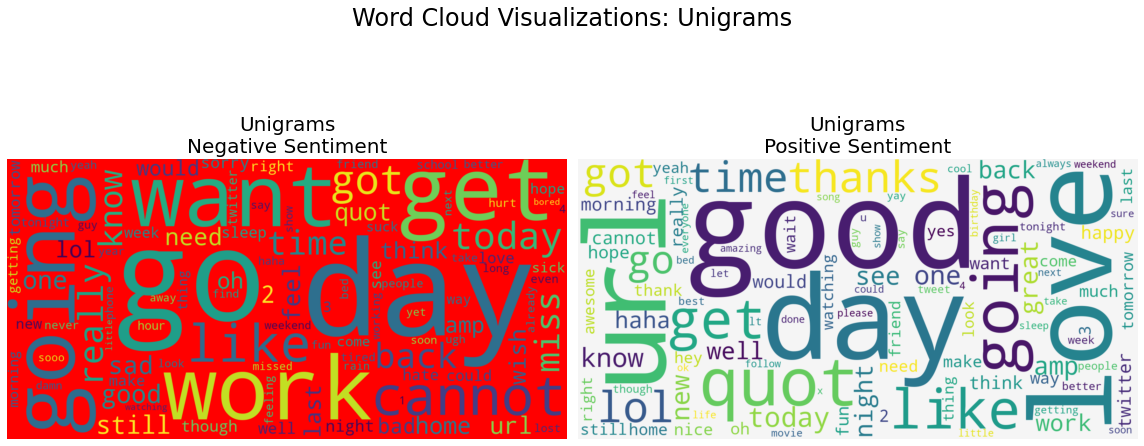

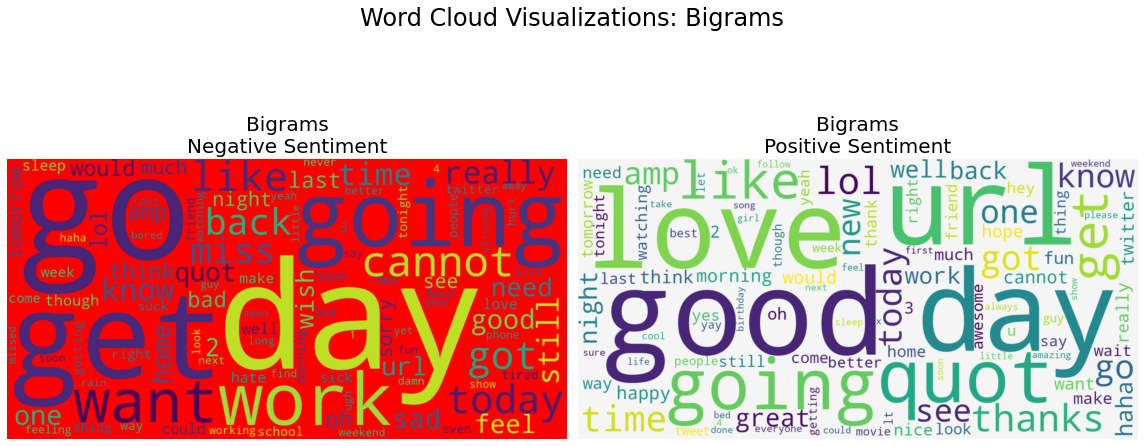

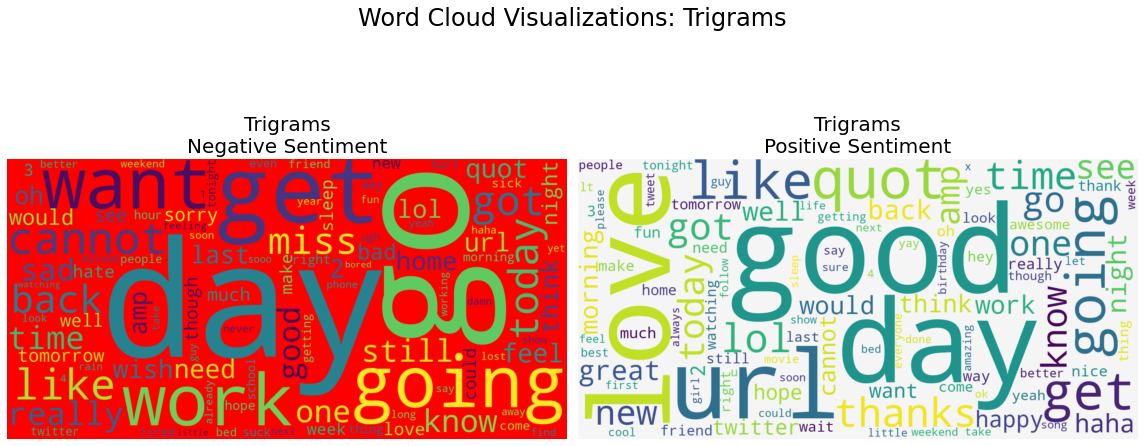

In [17]:
for feature_col in n_gram_options.keys():
    fig = plt.figure(figsize=(16, 16))
    rows, cols = 2, 2

    make_frequency_clouds(fig, token_counts.pos, token_counts.neg, feature_col, rows, cols, 0)

    fig.suptitle(f"Word Cloud Visualizations: {feature_col.title()}", fontsize=24)
    fig.tight_layout()
plt.show()
plt.close()

In [18]:
#df_processed.drop('text',inplace=True,axis=1)

In [13]:
from sklearn.model_selection import train_test_split

In [12]:
X = df_processed['tokens'].apply(lambda x: ' '.join(x))
y = df_processed['target']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
cv = CountVectorizer(analyzer = 'word',ngram_range=(1,6), stop_words='english')
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score

# train naive bayes classifier
clf = MultinomialNB()
clf.fit(X_train_cv, y_train)

# create predictions
y_pred = clf.predict(X_test_cv)

# find f-1 score
#score = f1_score(y_test, y_pred, average='micro')
score = accuracy_score(y_test, y_pred)
print('Accuracy score : {}'.format(np.round(score,4)))

F-1 score : 0.7669
